# USC CSCI 567 HW3

Author: Thamme Gowda N  
USCID: 2074669439

In [2]:
from __future__ import print_function
import random
import numpy as np
from matplotlib import pyplot as plt

## Bias Variance Trade-of

In [4]:
# Generate random data
def uniform_randoms(start, end, count):
    return [random.uniform(start, end) for _ in range(count)]

def generate_datasets(start, end, count, sets):
    return np.array([uniform_randoms(start, end, count) for _ in range(sets)])

# define f(x) 
def f(x, e=None):
    if e is None:
        e = random.gauss(0.0, 0.1)
    return 2 * x * x + e

def generate_ys(datasets):
    yss = []
    for xs in datasets:
        ys =[f(x) for x in xs]
        yss.append(ys)
    return np.array(yss)


In [103]:
def predict(X, W):
    return np.matmul(X, W)

def MSECost(Y2, Y1):
    return float(np.sum((Y2 - Y1) ** 2) / len(Y2))

def fit_line(X, Y):
    return np.matmul(
        np.matmul(
            np.linalg.pinv(np.matmul(X.transpose(), X)),
            X.transpose()),
        Y)

class LinearRegression(object):
    
    def __init__(self, X, Y):
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)
        X = self.normalize(X)
        self.W = fit_line(X, Y)
        #print(X.shape, self.W.shape, self.means, self.stds)

    def normalize(self, X):
        #print(X.shape, self.means.shape, self.stds.shape)
        X = (X - self.means) / self.stds
        # Bias is added as a weight to simplify the calculations
        X = np.insert(X, 0, 1, axis=1)
        return X
    
    def predict(self, X):        
        X = self.normalize(X)
        return np.matmul(X, self.W)
    
    def __repr__(self):
        return "W:%s, means:%s, Stds:%s" % (self.W, self.means, self.stds)

def phi(X, high, low=1):
    phi_X = np.zeros(shape=(len(X), 0))
    for power in range(low, high+1):
        phi_X = np.insert(phi_X, phi_X.shape[1], X ** power, axis=1)
    return phi_X


highest_poly_deg = 4
def report_bias_variance(n, num_ds):
    print("Number of datasets=%d, Number of Samples=%d" % (num_ds, n))
    datasets = generate_datasets(-1, 1, n, num_ds)
    test_set = generate_datasets(-1, 1, n, 1)[0]
    yss = generate_ys(datasets)
    test_ys = generate_ys([test_set])[0]
    '''
    plt.figure(1, figsize=(16, 24))
    # G1 is constant, no learning required, thus no regression 
    costs = np.zeros(num_ds)
    for i in range(num_ds): 
        Y =  yss[i]
        predY = np.array([1.0 for _ in range(len(Y))])
        costs[i] = MSECost(Y, predY)

    plt.subplot(4, 2, 1)
    plt.hist(costs, 10, facecolor='green', alpha=0.75)
    plt.xlabel('Mean Square Sum of errors')
    plt.ylabel('Counts')
    plt.title(r'$g_%d(x)=w^Tx$  $\mu=%f, \sigma=%f$.' % (1, costs.mean(), costs.std()))
    '''
    #print("Xs:",datasets)
    
    for j in range(highest_poly_deg + 1): # highest power of X
        print("Heighest power of X = ", j)
        #print("First phi(X):", phi(datasets[0], j))
        models = [LinearRegression(phi(datasets[i], j), yss[i]) for i in range(num_ds)]
        #print("First Model, W:", models[0].W, " Means:", models[0].means, ",STD:", models[0].stds)
        #print(models)
        
        phi_test_set = phi(test_set, j)
        #print("Phi(test_X)", phi_test_set)
        preds = np.zeros(shape=(num_ds, n))
        for row in range(num_ds):
            pred_y = models[row].predict(phi_test_set)
            for col in range(n):
                preds[row,col] = pred_y[col]
        
        #print("Predictions:", preds)
        avgx = preds.mean(axis=0) # averaging over datasets, axis=0 is data_sets
        #print("AvgX", avgx)
        spread = np.zeros(shape=(num_ds, n))
        for col in range(n):
            for row in range(num_ds):
                spread[row, col] = abs(preds[row,col] - avgx[col])
        #print("Spread:", spread)
        spread = spread ** 2
        #print("Variance:", (spread))
        variance = spread.mean(axis=0) # averaged over all the datasets
        #print("Ed[Variance]>>", variance)
        variance = variance.mean() # averaged over all the data points 
        print("EdEx[Variance]>>", variance)
        
        bias_2s = np.zeros(n)
        for i in range(n):
            bias_2s = (avgx[i] - test_ys[i])**2
        bias_2 = bias_2s.mean()
        print("Bias_2:", bias_2)
        '''
        plt.subplot(4, 2, 2 + j)
        plt.hist(costs, 10, facecolor='green', alpha=0.75)
        plt.xlabel('Mean Square Sum of errors')
        plt.ylabel('Counts')
        plt.title(r'$g_%d(x)=w^Tx$  $\mu=%f, \sigma=%f$.' % (j + 2, costs.mean(), costs.std()))
        '''
        print("========")

#    plt.show()
report_bias_variance(n=100, num_ds=100)

Number of datasets=100, Number of Samples=100
Heighest power of X =  0
EdEx[Variance]>> 0.00438860964223
Bias_2: 1.18927037892
Heighest power of X =  1
EdEx[Variance]>> 0.0100783164191
Bias_2: 1.12444287355
Heighest power of X =  2
EdEx[Variance]>> 0.000243687750151
Bias_2: 0.00563162363573
Heighest power of X =  3
EdEx[Variance]>> 0.000372396152192
Bias_2: 0.00624012015379
Heighest power of X =  4
EdEx[Variance]>> 0.000487650461554
Bias_2: 0.00629536049901


In [58]:
abcd = phi(generate_datasets(-1, 1, 10,1)[0], high=2)
print(abcd[0])
for a,b in enumerate(abcd):
    print(a,b)

[-0.16954892  0.02874684]
0 [-0.16954892  0.02874684]
1 [-0.0639178   0.00408548]
2 [ 0.02822935  0.0007969 ]
3 [ 0.84572544  0.71525152]
4 [-0.60561724  0.36677224]
5 [ 0.97113375  0.94310076]
6 [-0.78771006  0.62048714]
7 [-0.33488208  0.11214601]
8 [ 0.08636935  0.00745966]
9 [ 0.47034968  0.22122883]


Heighest power of X =  0
Heighest power of X =  1
Heighest power of X =  2
Heighest power of X =  3
Heighest power of X =  4


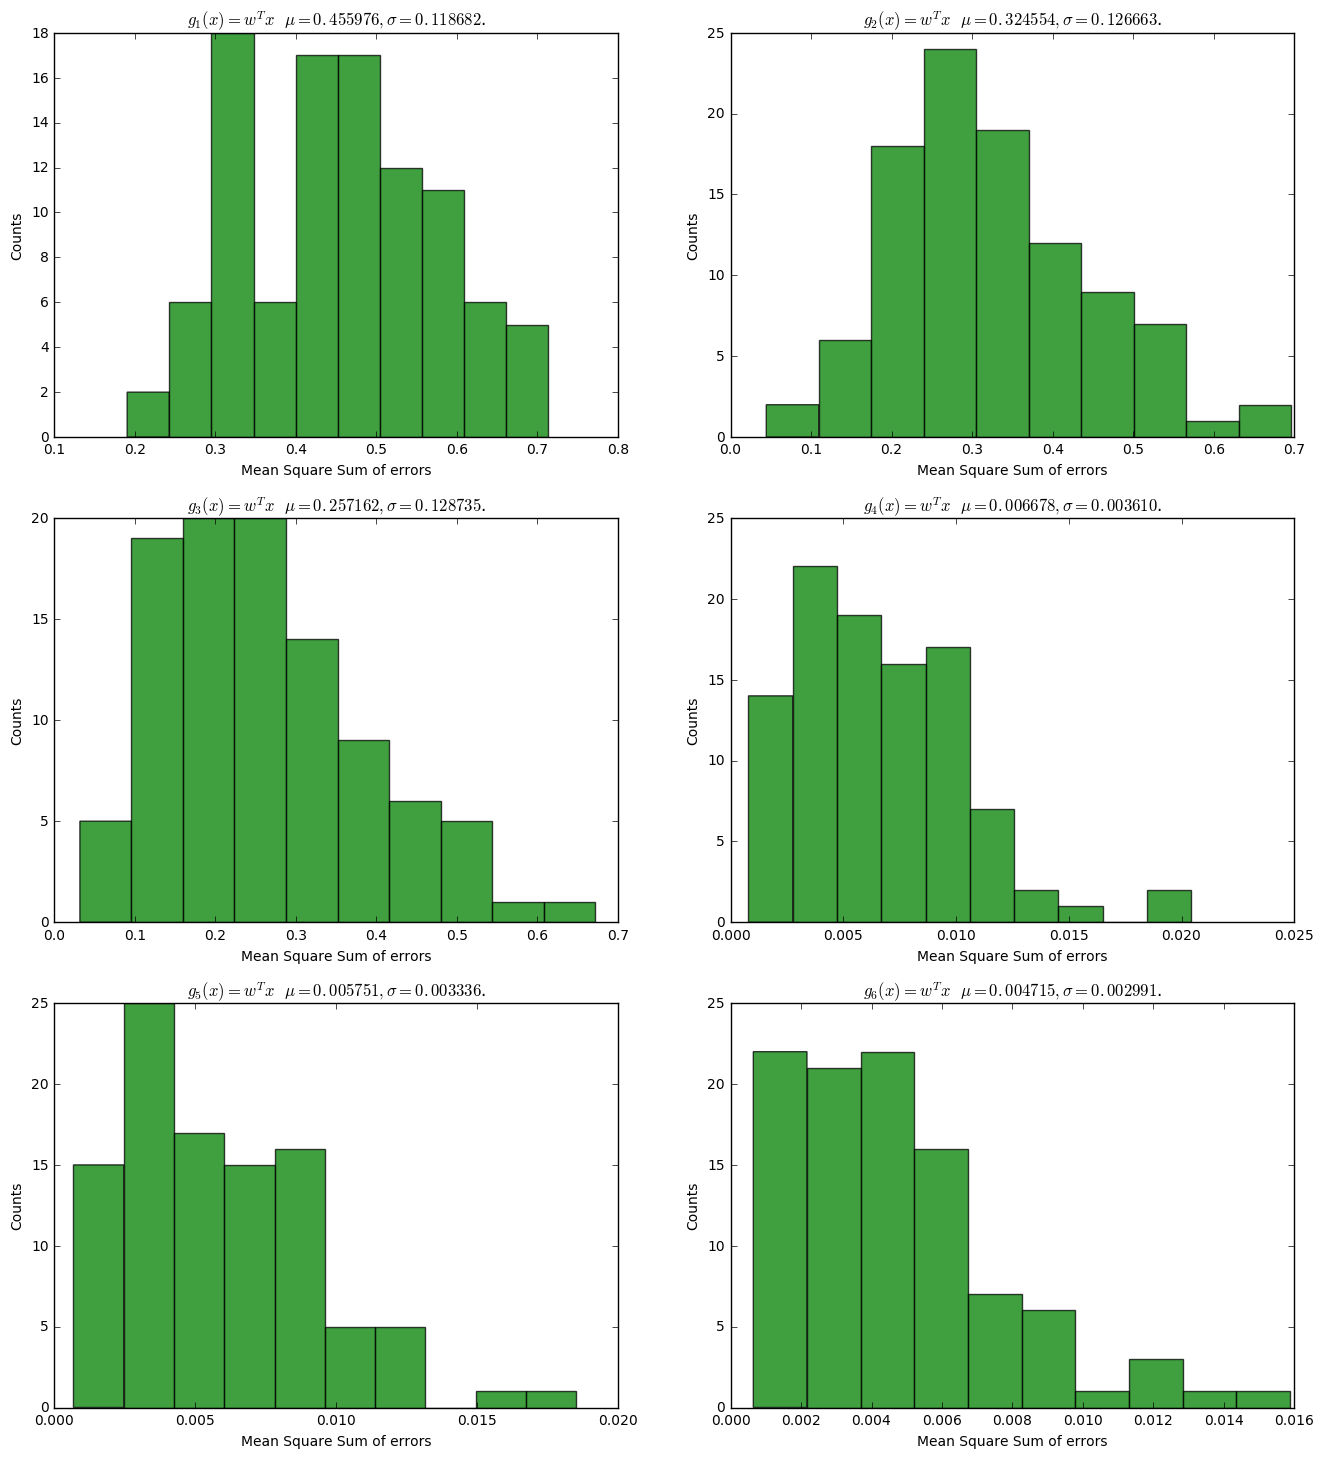

In [6]:
report_bias_variance(sample_size=10, num_ds=100)

Heighest power of X =  0
Heighest power of X =  1
Heighest power of X =  2
Heighest power of X =  3
Heighest power of X =  4


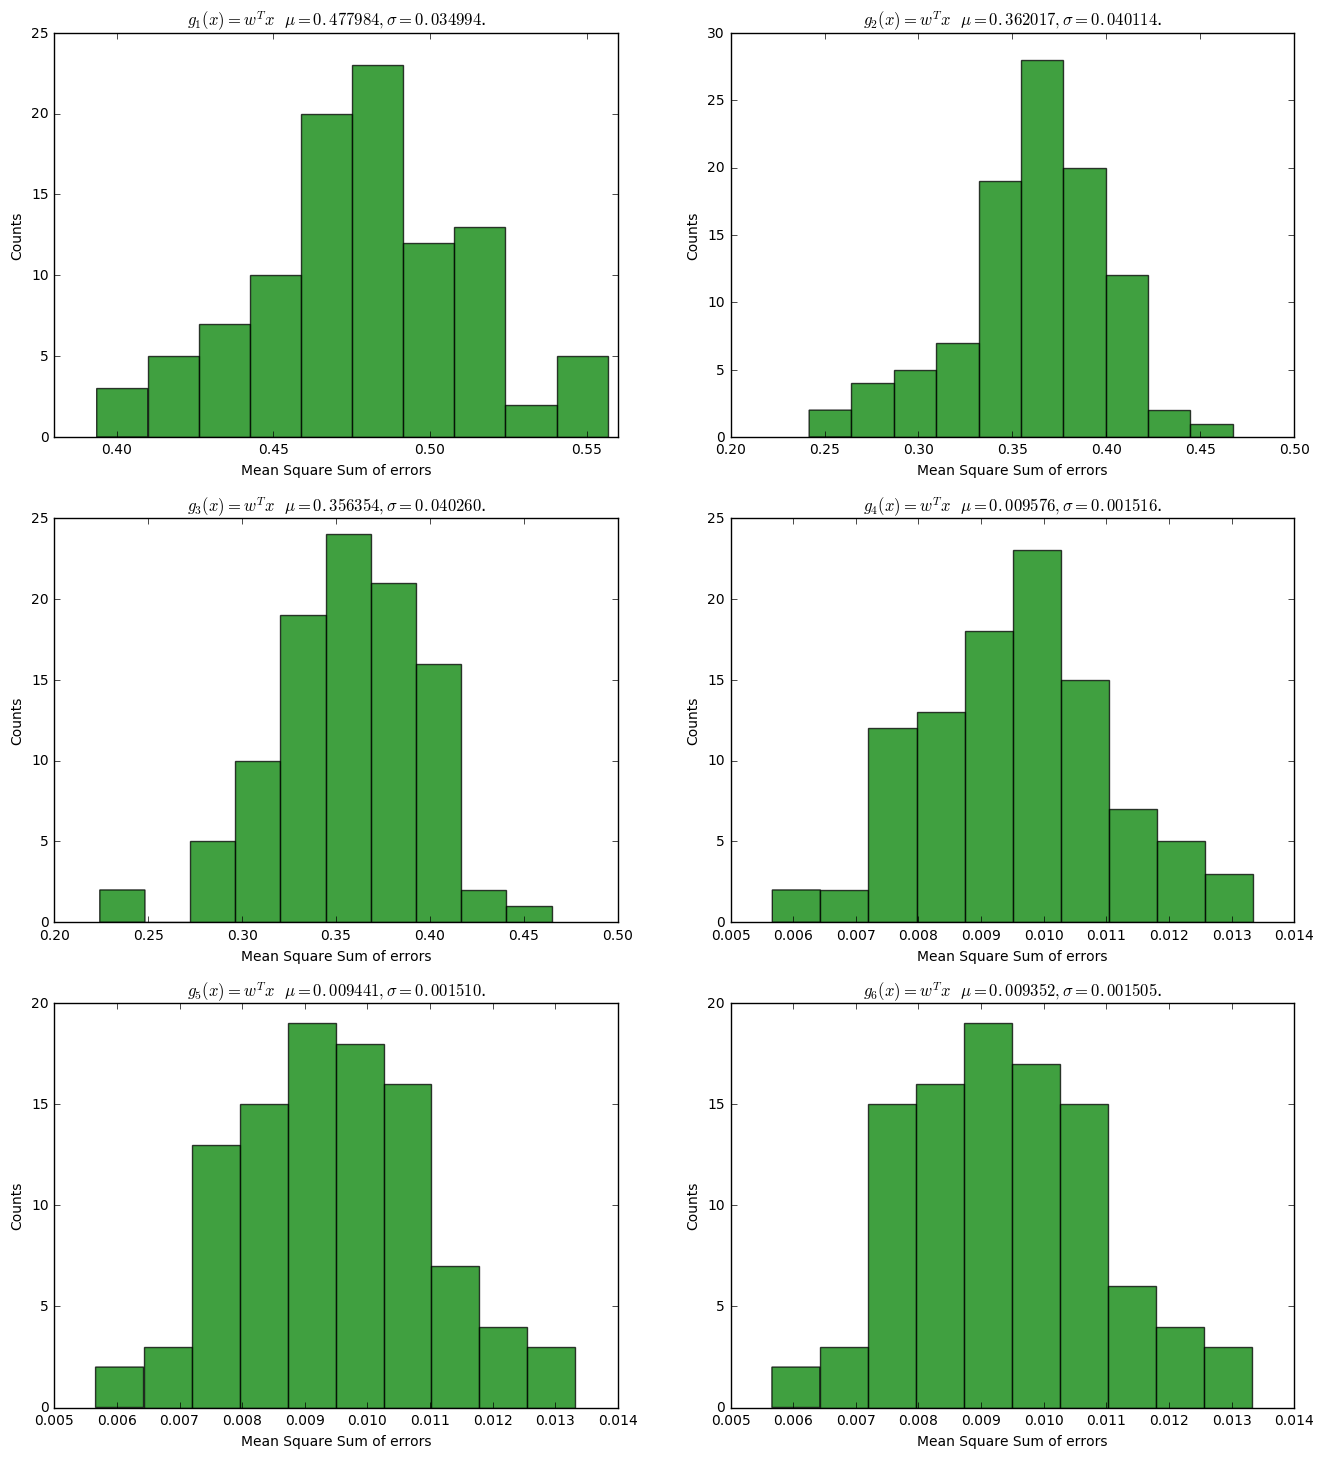

In [135]:
# Change sample size to 100
report_bias_variance(sample_size=100, num_ds=100)

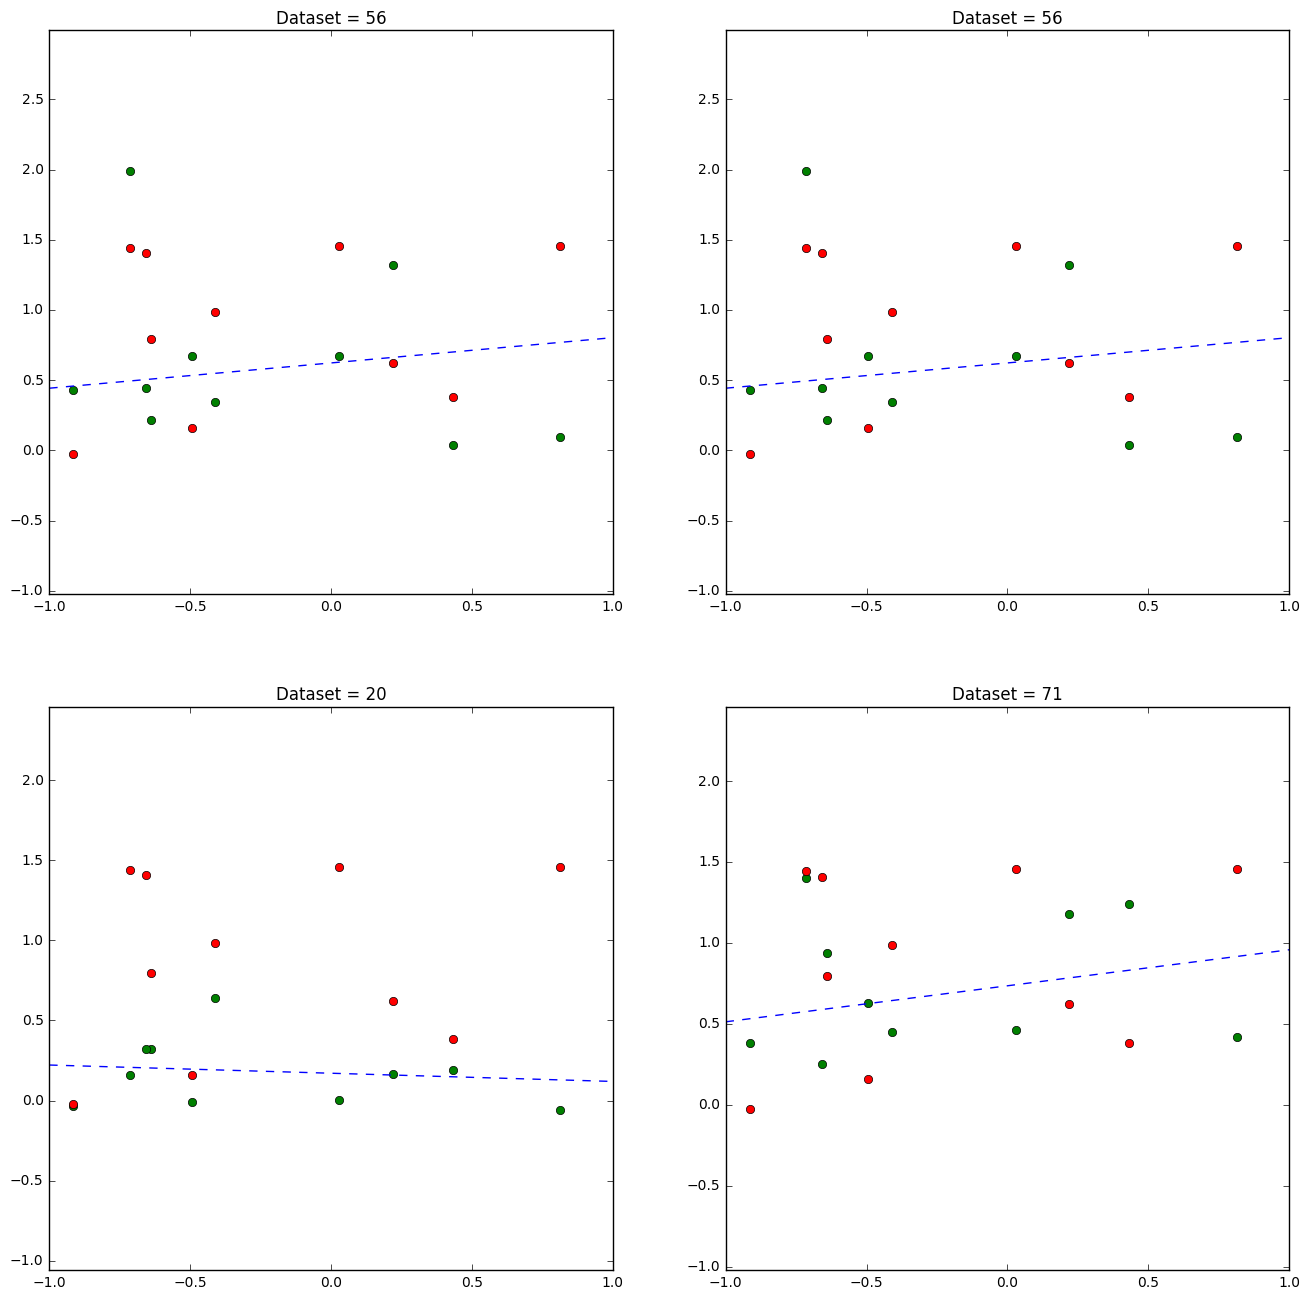

In [126]:
# To visualize lin regress line fitting
plt.figure(figsize=(16,16))
for j in range(4):
    i = random.randint(0, len(datasets))
    
    X = datasets[i].transpose().reshape((len(datasets[i]), 1))
    Y = yss[i]
    linreg = LinearRegression(X, Y)
    z = np.linspace(-1, 1)
    zz = linreg.W[1] * z + linreg.W[0]

    plt.subplot(2,2, 1 + j)
    plt.plot(datasets[0], Y, 'go', datasets[0], predY, 'ro', z, zz, '--')
    plt.xlim(-1, 1)
    plt.ylim(min(min(Y), min(predY)) - 1, max(max(Y), max(predY)) + 1)
    plt.title("Dataset = %d" % i)

plt.show()


# Support Vector Machines (SVM)

In [194]:
from scipy import io
test_file = '../data/phishing-test.mat'
train_file = '../data/phishing-train.mat'

def transform_features(X):
    newX = np.zeros(shape=(X.shape[0], 0))
    for i in range(X.shape[1]):
        vals = set(X[:, i])
        if len(vals) == 3: # break into three boolean cols
            for val in vals:
                new_col = map(lambda a: int(a == val), X[:, i])
                newX = np.insert(newX, newX.shape[1], new_col, axis=1)
        elif -1 in vals:
            new_col = map(lambda a: int(a > 0), X[:, i]) # replace -1 with 0
            newX = np.insert(newX, newX.shape[1], new_col, axis=1)
        else:
            newX = np.insert(newX, newX.shape[1], X[:, i], axis=1)
    return newX

def load_data(fn):
    mat = scipy.io.loadmat(train_file)
    Y = mat['label']
    X = mat['features']
    return transform_features(X), Y.flatten()

def store_svm_vectors(X, Y, file_name):
    assert(len(X) == len(Y))
    with open(file_name, 'wb') as f:
        for i in range(len(Y)):
            f.write("%d " % Y[i]) # label
            pairs = map(lambda t: "%d:%d"% t, enumerate(X[i]))
            f.write(" ".join(pairs)) # attributes
            f.write("\n")

X, Y = load_data(train_file)
testX, testY = load_data(test_file)

store_svm_vectors(X, Y, 'train.data')
store_svm_vectors(testX, testY, 'test.data')

In [228]:
%%script bash
pow(){
    python -c "from sys import argv as a; print(pow(int(a[1]), int(a[2])))" $1 $2
}

millis(){  python -c "import time; print(int(time.time()*1000))"; }

linear_kernel(){
    echo "Linear Kernel"
    START=$(millis)
    counter=0
    for i in $(seq -6 2); do
        c=$(pow 4 $i)
        echo "C=$c"
        svm-train -t 0 -c $c -v 3 train.data | grep "Accuracy"
        ((counter++))
    done;
    END=$(millis)
    DIFF=$(echo "$END - $START" | bc)
    echo "Total time taken:"$DIFF ", $counter experiments"
    echo "Average taken :" $(echo "$DIFF / $counter" | bc) "ms"
}

poly_kernel(){
    echo "Polynomial Kernel"
    START=$(millis)
    counter=0
    for i in $(seq -3 7); do
        c=$(pow 4 $i)
        for deg in $(seq 1 3); do
            echo "C=$c, degree=$deg"
            svm-train -t 1 -c $c -d $deg -v 3 train.data | grep "Accuracy"
            ((counter++))
        done;
    done;
    END=$(millis)
    DIFF=$(echo "$END - $START" | bc)
    echo "Total time taken:"$DIFF ", $counter experiments"
    echo "Average taken :" $(echo "$DIFF / $counter" | bc) "ms"
}
RBF_kernel(){
    echo "RBF Kernel"
    START=$(millis)
    counter=0
    for i in $(seq -3 7); do
        c=$(pow 4 $i)
        for j in $(seq -7 -1); do
            gamma=$(pow 4 $j)
            echo "C=$c, gamma=$gamma"
            svm-train -t 2 -c $c -g $gamma -v 3 train.data | grep "Accuracy"
            ((counter++))
        done;
    done;
    END=$(millis)
    DIFF=$(echo "$END - $START" | bc)
    echo "Total time taken:"$DIFF ", $counter experiments"
    echo "Average taken :" $(echo "$DIFF / $counter" | bc) "ms"
}

linear_kernel
poly_kernel
RBF_kernel

Linear Kernel
C=0.000244140625
Cross Validation Accuracy = 55.75%
C=0.0009765625
Cross Validation Accuracy = 88.2%
C=0.00390625
Cross Validation Accuracy = 91.35%
C=0.015625
Cross Validation Accuracy = 92.75%
C=0.0625
Cross Validation Accuracy = 93.9%
C=0.25
Cross Validation Accuracy = 94.6%
C=1
Cross Validation Accuracy = 94.65%
C=4
Cross Validation Accuracy = 94.5%
C=16
Cross Validation Accuracy = 94.4%
Total time taken:2823 , 9 experiments
Average taken : 313 ms
Polynomial Kernel
C=0.015625, degree=1
Cross Validation Accuracy = 55.75%
C=0.015625, degree=2
Cross Validation Accuracy = 55.75%
C=0.015625, degree=3
Cross Validation Accuracy = 55.75%
C=0.0625, degree=1
Cross Validation Accuracy = 90.35%
C=0.0625, degree=2
Cross Validation Accuracy = 89%
C=0.0625, degree=3
Cross Validation Accuracy = 74.9%
C=0.25, degree=1
Cross Validation Accuracy = 91.15%
C=0.25, degree=2
Cross Validation Accuracy = 92.15%
C=0.25, degree=3
Cross Validation Accuracy = 92.05%
C=1, degree=1
Cross Validation

In [239]:
from sklearn.svm import SVC
''' The highest was RBF 
C=256, gamma=0.015625
Cross Validation Accuracy = 97.2%
'''
C=256
gamma=0.015625
model = SVC(C=C, gamma=gamma, kernel='rbf', verbose=True)
model = model.fit(X, Y)

predY = model.predict(X)

accurate = sum([truth == predicted for truth, predicted in zip(Y, predY)])
print("Train Accuracy: %f" %(float(accurate)/len(predY)))  

predY = model.predict(testX)
accurate = sum([truth == predicted for truth, predicted in zip(testY, predY)])
print("Test Accuracy: %f" %(float(accurate)/len(predY)))  

[LibSVM]Train Accuracy: 0.985000
Test Accuracy: 0.985000
